In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'icv83551/assignments/assignment3/'
FOLDERNAME = "icv83551/assignments/assignment3/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

In [ ]:
# This downloads the COCO dataset to your Drive if it doesn't already exist
# (you should already have this dataset from a previous notebook!)
# Uncomment the following if you don't have it.
# %cd /content/drive/My\ Drive/$FOLDERNAME/icv83551/datasets/
# !bash get_coco_captioning.sh
# %cd /content/drive/My\ Drive/$FOLDERNAME

In [ ]:
# Some useful python libraries
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install decord

# State-of-the-Art Pretrained Image Models

In the previous exercise, you learned about [SimCLR](https://arxiv.org/abs/2002.05709) and how contrastive self-supervised learning can be used to learn meaningful image representations. In this notebook, we will explore two more recent models that also aim to learn high-quality visual representations and have demonstrated strong and robust performance on a variety of downstream tasks.


First, we will examine the [CLIP](https://github.com/openai/CLIP) model. Like SimCLR, CLIP uses a contrastive learning objective, but instead of contrasting two augmented views of the same image, it contrasts two different modalities: text and image. To train CLIP, OpenAI collected a large dataset of ~400M image-text pairs from the internet, including sources like Wikipedia and image alt text. The resulting model learns rich, high-level image features and has achieved impressive zero-shot performance on many vision benchmarks.

Next, we will explore [DINO](https://github.com/facebookresearch/dino), a self-supervised learning method for vision tasks that applies contrastive learning in a self-distillation framework with multi-crop augmentation strategy. The authors showed that the features learned by DINO ViTs are fine-grained and semantically rich with explicit information about the semantic segmentation of the image.




# CLIP

As explained above, CLIP's training objective incorporates both text and images, building upon the principles of contrastive learning. Consider this quote from the SimCLR notebook:
>The goal of the contrastive loss is to maximize agreement between the final vectors **$z_i = g(h_i)$** and **$z_j = g(h_j)$**.

Similarly, CLIP is trained to maximize agreement between two vectors. However, because these vectors come from different modalities, CLIP uses two separate encoders: a transformer-based Text Encoder and a Vision Transformer (ViT)-based Image Encoder. Note that some smaller, more efficient versions of CLIP use a ResNet as the Image Encoder instead of a ViT.

Run the cell below to visualize the training and inference pipeline of CLIP.

During the pretraining phase, each batch consists of multiple images along with their corresponding captions. Each image is independently processed by an Image Encoder—typically a visual model like a Vision Transformer (ViT) or a Convolutional Neural Network (ConvNet)—which produces an image embedding $I_n$. Likewise, each caption is independently processed by a Text Encoder to generate a corresponding text embedding $T_n$. Next, we compute the pairwise similarities between all image-text combinations, meaning each image is compared with every caption, and vice versa. The training objective is to maximize the similarity scores along the diagonal of the resulting similarity matrix -- that is, the scores for the matching image-caption pairs $(I_n, T_n)$.  Through backpropagation, the model learns to assign higher similarity scores to true matches than to mismatched pairs.

Through this setup, CLIP effectively learns to represent images and texts in a shared latent space. In this space, semantic concepts are encoded in a modality-independent way, enabling meaningful cross-modal comparisons between visual and textual inputs.



In [ ]:
from IPython.display import Image as ColabImage
ColabImage(f'/content/drive/My Drive/{FOLDERNAME}/CLIP.png')
# ColabImage('CLIP.png')

**Inline Question 1** -

Why does CLIP's learning depend on the batch size? If the batch size is fixed, what strategy can we use to learn rich image features?

$\color{blue}{\textit Your Answer:}$

**1. Why does CLIP's learning depend on the batch size?**
* **The Contrastive Objective:** CLIP is trained using a contrastive loss function. In a batch of size $N$, the model constructs an $N \times N$ similarity matrix. For every true image-text pair (the diagonal), there are $N-1$ negative/false pairs.
* **Task Difficulty & Hard Negatives:** As the batch size increases, the number of negative examples scales linearly. This makes the learning objective significantly more difficult because the model is more likely to encounter "hard negatives" (e.g., distinguishing an image of a "dog" from a caption about a "wolf"). To succeed, the model requires higher precision to assign the highest similarity score to the single correct pair among thousands of distractors. Consequently, larger batch sizes force the model to learn richer, more accurate representations.



**2. If the batch size is fixed, what strategies can we use to learn rich image features?**
When hardware constraints limit the batch size, we can enrich feature learning by artificially increasing the diversity of the data and the difficulty of the task:

* **Momentum Encoders & Memory Banks (e.g., MoCo):** This is an advanced form of negative sampling. Instead of relying only on the current mini-batch for negatives, we maintain a continuously updated "queue" (or memory bank) of feature embeddings from past batches. A slowly updating momentum encoder ensures these stored representations stay consistent. This effectively decouples the number of negative samples from the mini-batch size.

* **Hard Negative Mining:** Instead of treating all negative samples equally, the training process can explicitly identify and heavily penalize the "hardest" negatives (false pairs that the model currently scores with high similarity), providing a stronger gradient signal from a limited batch.
* **Heavy Data Augmentation:** Applying aggressive image augmentations (such as random cropping, color jittering, and blurring) creates multiple, distinct views of the same image. This forces the model to ignore superficial textures and focus on invariant, core semantic features to successfully match the augmented image with its caption.



# Loading COCO dataset

We'll use the same captioning dataset you used to train your RNN captioning model, but instead of generating the captions lets see if we can match each image to the correct caption.

In [2]:
#%load_ext autoreload
#%autoreload 2

import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import torch
import clip
import torch
from tqdm.auto import tqdm

from PIL import Image
from icv83551.clip_dino import *

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-10, np.abs(x) + np.abs(y))))


In [3]:
from icv83551.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from icv83551.image_utils import image_from_url

In [4]:
# Load COCO data from disk into a dictionary.
# this is the same dataset you used for the RNN captioning notebook :)
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  C:\Users\eitan\PythonProjects\CV_projects\assignment3\icv83551\datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


In [5]:
# we're just using the loaded captions from COCO, so we need to decode them and get rid of the special tokens.
decoded_captions= []
for caption in data['val_captions']:
  caption = decode_captions(caption, data['idx_to_word'])\
    .replace('<START>', '')\
    .replace('<END>', '')\
    .replace('<UNK>', '')\
    .strip()
  decoded_captions.append(caption)

In [6]:
# lets get 10 examples
mask = np.array([135428, 122586, 122814, 133173, 176639, 163828,  98169,   6931,
        19488, 175760])
first_captions = [decoded_captions[elem] for elem in mask]

img_idxs = data['val_image_idxs'][mask]       # the images the captions refer to
first_images   = [image_from_url(data['val_urls'][j]) for j in img_idxs]

In [ ]:
for i, (caption, image) in enumerate(zip(first_captions, first_images)):
    plt.imshow(image)
    plt.axis('off')
    caption_str = caption
    plt.title(caption_str)
    plt.show()

# Running the CLIP Model

First we'll use the pretrained CLIP model to extract features from the texts and images separetely.

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
# You can check the model layers by printing the model.
# CLIP's model code is available at https://github.com/openai/CLIP/tree/main/clip
# print(clip_model)

In [9]:
# First, we encode the captions into vectors in the shared embedding space.
# Since we're using a Transformer as the text encoder, we need to tokenize the text first.
text_tokens = clip.tokenize(first_captions).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)

# Sanity check, print the shape
print(text_features.shape)

torch.Size([10, 512])


C:\Users\eitan\PythonProjects\CV_projects\assignment3\.venv\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [10]:
# Then, we encode the images into the same embedding space.
processed_images = [
    clip_preprocess(Image.fromarray(img)).unsqueeze(0)
    for img in first_images
]
images_tensor = torch.cat(processed_images, dim=0).to(device)

with torch.no_grad():
    image_features = clip_model.encode_image(images_tensor)

# sanity check, print the shape
print(image_features.shape)

torch.Size([10, 512])


Open `icv83551/clip_dino.py` and implement `get_similarity_no_loop` to compute similarity scores between text features and image features. Test your implementation below, you should see relative errors less than 1e-5.

In [11]:
from icv83551.clip_dino import get_similarity_no_loop
torch.manual_seed(231)
np.random.seed(231)
M, N, D = 5, 6, 10

test_text_features = torch.randn(N, D)
test_image_features = torch.randn(M, D)
out = get_similarity_no_loop(test_text_features, test_image_features)

expected_out = np.array([
    [ 0.1867811 , -0.23494351,  0.44155994, -0.18950461,  0.00100103],
    [ 0.17905031, -0.25469488, -0.64330417,  0.25097957, -0.09327742],
    [-0.4407011 , -0.4365381 ,  0.32857686, -0.3765278 ,  0.01049389],
    [ 0.24815483,  0.42157224, -0.08459304,  0.14132318, -0.26935193],
    [ 0.02309848, -0.01441101,  0.5469337 ,  0.6018773 ,  0.21581158],
    [ 0.41579214, -0.014449  , -0.7242257 ,  0.39348006,  0.0822239 ],
]).astype(np.float32)

print("relative error: ", rel_error(out.numpy(), expected_out))

relative error:  8.547796e-06


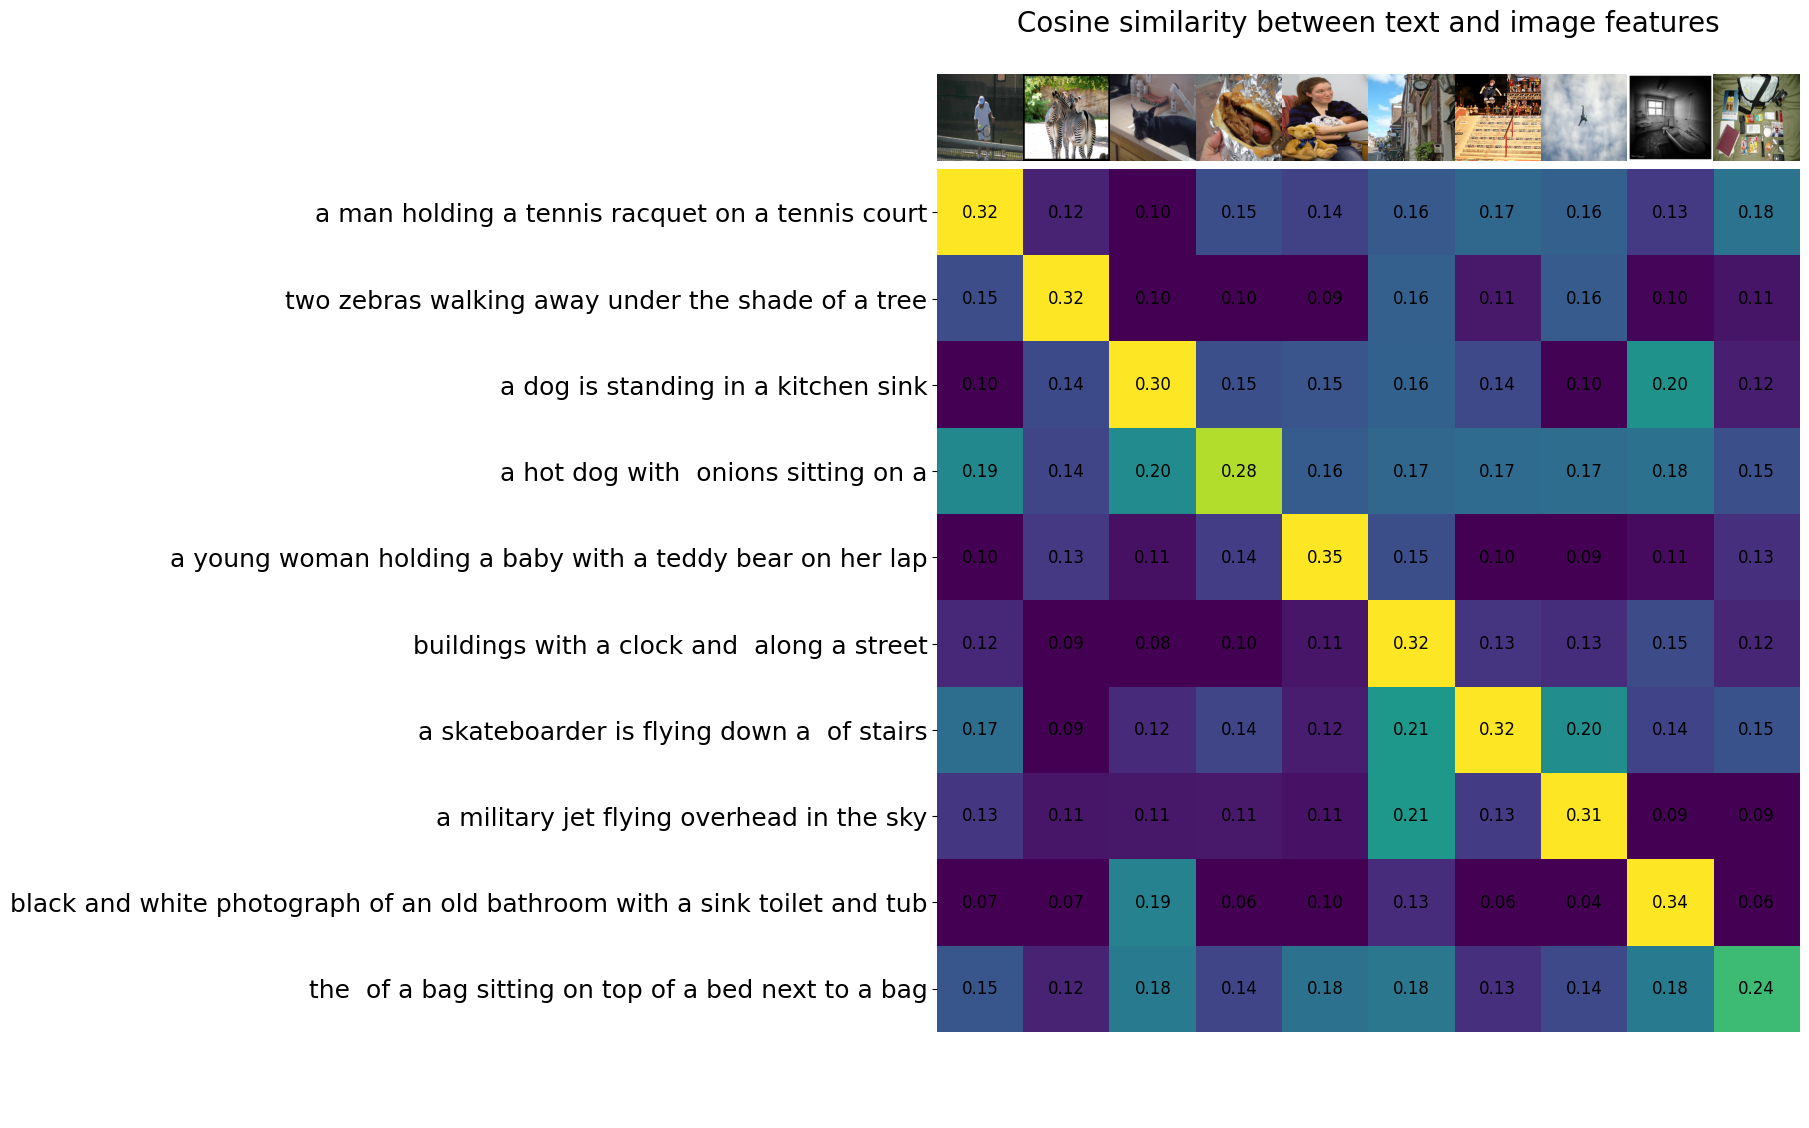

In [12]:
# Let's visualize the similarities between our batch of images and their captions.

similarities = get_similarity_no_loop(text_features, image_features).cpu().detach().numpy()

plt.figure(figsize=(20, 14))
plt.imshow(similarities, vmin=0.1, vmax=0.3)
plt.yticks(range(len(text_features)), first_captions, fontsize=18)
plt.xticks([])
for i, image in enumerate(first_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarities.shape[1]):
    for y in range(similarities.shape[0]):
        plt.text(x, y, f"{similarities[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, len(image_features) - 0.5])
plt.ylim([len(text_features) + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)
plt.show()

# Zero Shot Classifier

You will be able to see a high similarity between matching image-caption pairs above. We can leverage this property to design an image classifier that doesn't require any labeled data (i.e., a zero-shot classifier). Each class can be represented using an appropriate natural language description, and any input image will be classified into the class whose description has the highest similarity with the image in CLIP's embedding space.

Implement `clip_zero_shot_classifier` in `icv83551/clip_dino.py` and test it below. You should be able to see the following predictions:

['a person', 'an animal', 'an animal', 'food', 'a person', 'a landscape', 'other', 'other', 'other', 'a person']

In [13]:
from icv83551.clip_dino import clip_zero_shot_classifier

classes = ["a person", "an animal", "food", "a landscape", "other"]

pred_classes = clip_zero_shot_classifier(
    clip_model, clip_preprocess, first_images, classes, device)

print(pred_classes)

['a person', 'an animal', 'an animal', 'food', 'a person', 'a landscape', 'other', 'other', 'other', 'a person']


Run the cell below to visualize the predictions. As you can see, CLIP offers a straightforward way to perform reasonable zero-shot classification across any class taxonomy.

CLIP was the first model to outperform standard supervised training on ImageNet classification without using any ImageNet images or labels (The original CLIP paper has many such interesting experiments and analysis).


In [ ]:
# Visualize the zero shot predictions
for i, (pred_class, image) in enumerate(zip(pred_classes, first_images)):
    plt.imshow(image)
    plt.axis('off')
    plt.title(pred_class)
    plt.show()

# Image Retrieval using CLIP

Just as we used CLIP to retrieve the matching class name for each image, we can also use it to retrieve matching images from text inputs (semantic image retrieval). Implement the `CLIPImageRetriever` in `icv83551/clip_dino.py` and test it by running the two cells below. The expected top 2 outputs for each query are provided in the comments.

In [15]:
from icv83551.clip_dino import CLIPImageRetriever
clip_retriever = CLIPImageRetriever(clip_model, clip_preprocess, first_images, device)

In [ ]:
query = "sports"  # tennis, skateboard
# query = "black and white"  # bathroom, zerbas
img_indices = clip_retriever.retrieve(query)

for img_index in img_indices:
    plt.imshow(first_images[img_index])
    plt.axis('off')
    plt.show()

**Inline Question 2** -

CLIP learns to align image and text representations in a shared latent space using a contrastive loss. How would you extend this idea to more than two modalities?

$\color{blue}{\textit Your Answer:}$

The most effective way to extend CLIP's contrastive learning to more than two modalities is to project all data into a shared embedding space and compute pairwise contrastive losses.


**1. Shared Latent Space & Encoders**
* Instead of just an image and text encoder, we introduce a dedicated neural network encoder for each additional modality (e.g., audio, depth, or thermal data).
* A linear projection head is applied to the output of each encoder to map the features into the same $D$-dimensional shared latent space.

**2. Pairwise Similarity Matrices**
* We compute cosine similarities between pairs of modalities rather than combining them into a single generalized fraction.
* Let $X_i \in \mathbb{R}^{B \times D}$ and $X_j \in \mathbb{R}^{B \times D}$ represent batches of $B$ L2-normalized embeddings for modalities $i$ and $j$.
* The similarity matrix between these two specific modalities is simply their dot product: $S_{i,j} = X_i X_j^T$, resulting in a $B \times B$ matrix of similarity scores.

**3. Generalized Contrastive Loss & Anchoring**
* The total loss can be the sum of the standard symmetric contrastive losses (InfoNCE) computed for pairs of modalities.
* **Efficiency Strategy:** Computing the loss for every possible pair scales poorly ($O(M^2)$). Instead, we can designate one modality—typically images—as the "anchor". By solely aligning all other modalities to the image anchor, they implicitly align with one another (e.g., audio aligns with text without ever seeing an explicit audio-text pair during training).


# DINO

As mentioned earlier, models trained with vanilla contrastive learning methods such as SimCLR and CLIP require very large batch sizes. This makes them computationally expensive and limits their accessibility. Subsequent works, like [BYOL](https://arxiv.org/abs/2006.07733), propose an alternative approach that avoids the need for numerous negative samples by using a student-teacher framework. This method performs surprisingly well and was later adopted by [DINO](https://arxiv.org/abs/2104.14294) .

Similar to SimCLR, DINO is trained to maximize the agreement between two vectors derived from different views of the same image. However, unlike SimCLR, DINO uses two separate encoders which are trained differently. The student network is updated via backpropagation to match the outputs of the teacher network. The teacher network is not updated via backpropagation; instead, its weights are updated using an exponential moving average (EMA) of the student's weights. This means that the teacher model evolves more slowly and provides a stable target for the student to learn from.

Run the cell below to visualize the DINO training pipeline.

In [ ]:
from IPython.display import Image as ColabImage
ColabImage(f'/content/drive/My Drive/{FOLDERNAME}/dino.gif')
# ColabImage('dino.gif')

In [17]:
# first let's get rid of the CLIP model that's currently using memory
del clip_model
# Uncomment the following if you are using GPU runtime
# torch.cuda.empty_cache()
# torch.cuda.ipc_collect()

In [18]:
# Load smallest dino model. ViT-S/8. Here ViT-S has ~22M parameters and
# works on 8x8 patches.
dino_model = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
dino_model.eval().to(device)


Using cache found in C:\Users\eitan/.cache\torch\hub\facebookresearch_dino_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [ ]:
# the image we will be playing around with
sample_image = Image.fromarray(first_images[0]).convert("RGB")
sample_image

# DINO Attention Maps

Since the loaded DINO checkpoint is based on the ViT architecture, we can visualize what each attention head is focusing on. The code below generates heatmaps showing which patches of the original image the [CLS] token attends to across the various heads in the final layer. Although this model was trained using a self-supervised objective without any explicit instruction to recognize "structure" in images, still...

Do you notice any patterns?

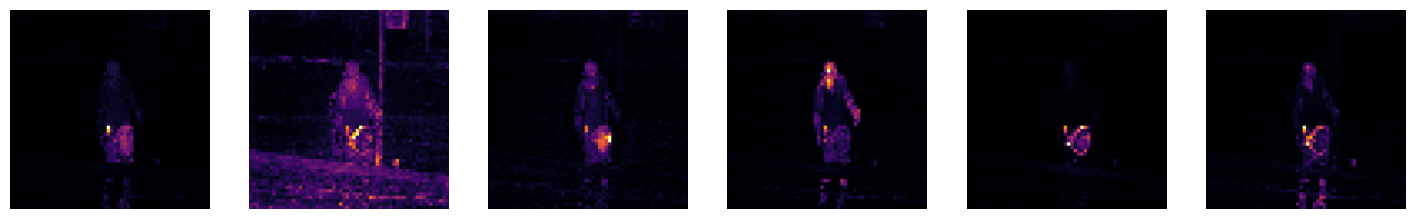

In [20]:
# Preprocess
from torchvision import transforms as T
transform = T.Compose([
    T.Resize((480, 480)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img_tensor = transform(sample_image)
w, h = img_tensor.shape[1:]
img_tensor = img_tensor[None].to(device)

# Extract attention
with torch.no_grad():
    attn = dino_model.get_last_selfattention(img_tensor)[0, :, 0, 1:]
nh, tokens = attn.shape
w_feat, h_feat = w // 8, h // 8
attn = attn.reshape(nh, w_feat, h_feat)
attn = torch.nn.functional.interpolate(attn.unsqueeze(0), scale_factor=8, mode="nearest")[0].cpu().numpy()

# Plot attention heads
fig, axes = plt.subplots(1, nh, figsize=(3 * nh, 3))
for i in range(nh):
    ax = axes[i] if nh > 1 else axes
    ax.imshow(attn[i], cmap='inferno')
    ax.axis('off')
plt.show()

In [21]:
# Extract patch token features and discard [CLS] token.
with torch.no_grad():
    all_tokens = dino_model.get_intermediate_layers(img_tensor, n=1)[0]  # (1, 1+N, D)
    patch_tokens = all_tokens[:, 1:, :]  # (N, D)

print(img_tensor.shape)
print(all_tokens.shape)
print(patch_tokens.shape)

torch.Size([1, 3, 480, 480])
torch.Size([1, 3601, 384])
torch.Size([1, 3600, 384])



**Inline Question 3**

How do we get the tensor shapes printed above? Explain your answer.


$\color{blue}{\textit Your Answer:}$

**`(1, 3, 480, 480)`:** This represents a single RGB image sample as a batch:
* The image is RGB, providing **3** color channels.
* `T.Resize` scales the spatial dimensions to **480x480**.
* `img_tensor[None]` adds the initial batch size of **1**.

**`(1, 3601, 384)`:** This tensor holds the sequence of tokens representing the image:
* The image is split into **3600** ViT patches, implying a patch size of **8x8** (since 480 / 8 = 60, and 60 * 60 = 3600).
* **1** extra token is prepended for the class (`[CLS]`).
* The embedding dimension for each token is **384**.

**`(1, 3600, 384)`:** This is the identical sequence from above, but with the class token removed:
* It isolates just the **3600** spatial image patches, dropping the `[CLS]` token entirely.

# DINO Features

To understand what the model is encoding in each patch, we can visualize the contents of each patch token. Since these embeddings are high-dimensional and difficult to interpret directly, we'll use PCA to identify the directions of highest variance in the feature space.

In the next cell, we visualize the three principal directions of variance in the feature space. This reveals the dominant structure that the patch embeddings are capturing.

In [ ]:
from sklearn.decomposition import PCA

np.random.seed(231)

# PCA
pca = PCA(n_components=3)
patch_pca = pca.fit_transform(patch_tokens.cpu().numpy()[0])

# Normalize PCA components to [0, 1] for RGB display
patch_rgb = (patch_pca - patch_pca.min(0)) / (patch_pca.max(0) - patch_pca.min(0))

# Reshape to image grid (60x60, 3)
patch_rgb_img = patch_rgb.reshape(60, 60, 3)

# Show as image
plt.figure(figsize=(6, 6))
plt.imshow(patch_rgb_img)
plt.axis('off')
plt.title("Patch Embeddings (PCA → RGB)")
plt.show()

**Inline Question 4** -

What kind of structure do you see in the visualization above? What does it imply when a region consistently appears in a specific color? What does it mean when two regions have distinctly different color? Remember that PCA reveals the directions of highest variance in the feature space across all patches. A patch's color reflects its distinct feature content.


$\color{blue}{\textit Your Answer:}$

**1. What kind of structure do you see in the visualization above?**
* **Semantic Structure:** The PCA reveals the dominant variations in the patch features. By mapping these high-dimensional embeddings to RGB colors, the structure reflects how the model implicitly parses and distinguishes different parts of the image based on feature variance.

**2. What does it imply when a region consistently appears in a specific color?**
* **Meaningful Segmentation:** A consistent color means the patches in that physical region share highly similar latent embeddings. This implies the model has successfully learned to group them together into a cohesive, meaningful segment (e.g., recognizing all those patches belong to a "person").

**3. What does it mean when two regions have distinctly different colors?**
* **Semantic Differences:** Distinct colors represent a large distance between embeddings in the feature space. This indicates that the model recognizes the two regions as fundamentally different semantic entities (e.g., clearly separating a "person" from the "background").


# A Simple Segmentation Model over DINO Features

In the previous section, we saw that DINO features can provide surprisingly good segmentation cues. Now, let's put that idea to the test by training a simple segmentation model on the [DAVIS dataset](https://davischallenge.org). The DAVIS dataset (Densely Annotated VIdeo Segmentation) was created for video object segmentation tasks. It provides frame-by-frame, pixel-level annotations of objects within videos. For this experiment, we'll train our model using the annotations from just a single frame of a video and see how well it performs on the remaining frames of the same.

Our model will be intentionally minimal: we'll extract DINO features per patch and train a lightweight per-patch classifier using only the patches from that one annotated frame. Typically, you would train on the full dataset and evaluate on a separate validation set containing different videos. But here, we will test the one-shot capabilities of DINO features.







In [23]:
from icv83551.clip_dino import DavisDataset

# A helper class to work with DAVIS dataset.
# It may take ~5 minutes on the first run of this cell to download the dataset.
davis_ds = DavisDataset()

# Get a specific test video. Do NOT change this for submission.
frames, masks = davis_ds.get_sample(7)
num_classes = masks.max() + 1

print(frames.shape, masks.shape, num_classes)

video soapbox  99 frames
(99, 480, 854, 3) (99, 480, 854, 1) 4


In [24]:
# Get DINO patch features and corresponding class labels for a middle frame
train_fi = 40
X_train = davis_ds.process_frames(frames[train_fi:train_fi+1], dino_model, device)[0]
Y_train = davis_ds.process_masks(masks[train_fi:train_fi+1], device)[0]
print(X_train.shape, Y_train.shape)

torch.Size([3600, 384]) torch.Size([3600])


Complete the implementation of the `DINOSegmentation` class in `icv83551/clip_dino.py`, and test it by running the two cells below. You should achieve a mean IoU greater than 0.45 on the first test frame and greater than 0.50 on the last test frame. To prevent overfitting on the training patch features, consider designing a very lightweight model (e.g., a linear layer or a 2-layer MLP) and applying appropriate weight decay.

You may use GPU runtime to speed up training and evaluation. Make sure to rerun the entire notebook if you change runtime type.

In [25]:
from icv83551.clip_dino import DINOSegmentation, compute_iou
torch.manual_seed(231)
np.random.seed(231)
dino_segmentation = DINOSegmentation(device, num_classes)
dino_segmentation.train(X_train, Y_train, num_iters=500)


# Test on first, middle, and last frame
ious = []
test_fis = [0, train_fi, 98]
gt_viz = []
pred_viz = []
for fi in test_fis:
  X_test = davis_ds.process_frames(frames[fi:fi+1], dino_model, device)[0]
  Y_test = davis_ds.process_masks(masks[fi:fi+1], device)[0]
  Y_pred = dino_segmentation.inference(X_test)
  iou = compute_iou(Y_pred, Y_test, num_classes)
  ious.append(iou)

  gt_viz.append(davis_ds.mask_frame_overlay(Y_test, frames[fi]))
  pred_viz.append(davis_ds.mask_frame_overlay(Y_pred, frames[fi]))

gt_viz = np.concatenate(gt_viz, 1)
pred_viz = np.concatenate(pred_viz, 1)

Training: 100%|██████████| 500/500 [00:01<00:00, 340.17it/s, loss=0.000962]


In [26]:
print(f"Mean IoU on first test frames: {ious[0]:.3f}")  # should be >0.45
print(f"Mean IoU on last test frames: {ious[2]:.3f}")  # should be >0.50

Mean IoU on first test frames: 0.493
Mean IoU on last test frames: 0.561


Now let's visualize the results. Run the two cells below to display the ground truth and predicted segmentation masks for the first, middle, and last frames. Note that the middle frame is part of the training set, while the other frames are unseen.

In [ ]:
Image.fromarray(gt_viz)

In [ ]:
Image.fromarray(pred_viz)

Now run the following three cells to evaluate and visualize the entire video. You should achieve a mean IoU greater than 0.55. The saved visualization video may take some time to process in Google Drive, but you can download it to your computer and view it locally.



In [28]:
# Run on all frames
ious = []
gt_viz = []
pred_viz = []
for fi in range(len(frames)):
  if fi % 20 == 0:
    print(f"{fi} / {len(frames)}")
  X_test = davis_ds.process_frames(frames[fi:fi+1], dino_model, device)[0]
  Y_test = davis_ds.process_masks(masks[fi:fi+1], device)[0]
  Y_pred = dino_segmentation.inference(X_test)
  iou = compute_iou(Y_pred, Y_test, num_classes)
  ious.append(iou)

  gt_viz.append(davis_ds.mask_frame_overlay(Y_test, frames[fi]))
  pred_viz.append(davis_ds.mask_frame_overlay(Y_pred, frames[fi]))

gt_viz = np.stack(gt_viz)  # T x H x W x 3
pred_viz = np.stack(pred_viz)  # T x H x W x 3
final_viz = np.concatenate([gt_viz, pred_viz], -2)  # T x H x 2W x 3

0 / 99
20 / 99
40 / 99
60 / 99
80 / 99


In [30]:
print(f"Mean IoU on all frames: {sum(ious) / len(ious):.3f}")  # should be >0.55


Mean IoU on all frames: 0.660


In [ ]:
def write_video_from_array(array, output_path, fps = 12):
    T, H, W, _ = array.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (W, H))
    for i in range(T):
        frame = array[i]
        out.write(frame)
    out.release()
    print(f"Video saved to {output_path}")


# It might take a while to process in google drive but you can just download it and watch on your computer
write_video_from_array(final_viz, "dino_res.mp4")
# write_video_from_array(final_viz, f"/content/drive/My Drive/{FOLDERNAME}/dino_res.mp4")

**Inline Question 5** -

If you train a segmentation model on CLIP ViT's patch features, do you expect it to perform better or worse than DINO? Why should that be the case?



$\color{blue}{\textit Your Answer:}$

You should expect the model trained on CLIP to perform **worse** than DINO.

**1. CLIP: Global Semantic Alignment**
* **The Objective:** CLIP is trained using contrastive learning to align an entire image's latent space with a corresponding text caption.
* **The Result:** Because of this image-level text supervision, CLIP's Vision Transformer focuses heavily on high-level, global semantics (e.g., identifying that the concept of a "dog" exists somewhere in the frame). It is fundamentally not designed to be spatially aware. As a result, its patch features struggle to understand precise object boundaries, making them poorly suited for dense, pixel-level tasks without heavy fine-tuning.

**2. DINO: Spatial & Structural Awareness**
* **The Objective:** DINO is trained using image-only self-supervised learning (SSL). Its training paradigm explicitly forces the network to match representations using different augmented crops (combining both local and global views) of the exact same image.
* **The Result:** This "local-to-global" consistency training forces DINO to learn rich spatial hierarchies, dense feature correspondences, and fine-grained visual structures. Consequently, DINO's patch features naturally group into cohesive, spatially-aware segments and capture sharp object boundaries out-of-the-box, making them significantly superior for pixel-wise tasks like semantic segmentation.
